In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
import seaborn as sns
import numpy as np

from src import datasets, metrics

In [2]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [5]:
# data paths
trainfile = datadir / (config['arrhythmia'] + '_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

In [6]:
train_df = pd.read_parquet(trainfile)
test_df = pd.read_parquet(testfile)

In [10]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

# Separate majority and minority classes
majority_class = train_df[train_df['target'] == 0]  # e.g., normal heartbeats
minority_class = train_df[train_df['target'] != 0]  # e.g., abnormal heartbeats

# Oversample the minority class
minority_oversampled = resample(minority_class, 
                                replace=True,      # Sample with replacement
                                n_samples=len(majority_class),  # Make the minority class as large as majority class
                                random_state=42)   # For reproducibility

# Combine the majority class with the oversampled minority class
df_oversampled = pd.concat([majority_class, minority_oversampled])

# Shuffle the dataset to randomize the order
df_oversampled = df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)
df_oversampled.to_parquet(datadir / 'heart_big_oversampled_train.parq')


In [7]:
trainfile = datadir / (config['arrhythmia'] + '_oversampled_full_train.parq')

In [8]:
#loading the datasets 
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")
traindataset, testdataset

# moving to mps device crashes the jupyter kernel

(Heartdataset (len 275000), Heartdataset (len 21892))

In [9]:
x, y = traindataset[0]
x.shape
# 192 bestaat uit 187 data punten en 5 classes of zijn dat channels?

torch.Size([192, 1])

In [10]:
# creating the datastreamers
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(8593, 684)

In [11]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 192, 1]), torch.Size([32]))

In [12]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [13]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("GRU model")

<Experiment: artifact_location='/Users/francesca/code_repo/MADS-exam-25/notebooks/mlruns/3', creation_time=1737058606106, experiment_id='3', last_update_time=1737058606106, lifecycle_stage='active', name='GRU model', tags={}>

In [14]:
class GRUmodel(nn.Module):
    def __init__(
        self,
        config: dict,
    ) -> None:
        super().__init__()
        print(config)
        self.rnn = nn.GRU(
            input_size=config["input"],
            hidden_size=int(config["hidden"]),
            dropout=config["dropout"],
            batch_first=True,
            num_layers=int(config["num_layers"]),
        )
        self.linear = nn.Linear(int(config["hidden"]), config["output"])

    def forward(self, x):
        x, _ = self.rnn(x)
        last_step = x[:, -1, :]
        yhat = self.linear(last_step)
        return yhat

In [18]:
#from src import models
#config GRU
config = {
    "input": 1,
    "hidden": 64,  
    "dropout": 0.4,
    "output": 5,
    "num_layers": 2,
    
}
model = GRUmodel(config)

{'input': 1, 'hidden': 64, 'dropout': 0.4, 'output': 5, 'num_layers': 2}


In [19]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heartGRU",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"patience": 2, "factor": 0.5},
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "GRU")
    mlflow.set_tag("dataset", "heart_big_oversampled")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        )
    trainer.loop()

2025-01-20 19:55:15.972 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heartGRU/20250120-195515
100%|██████████| 1718/1718 [01:17<00:00, 22.06it/s]
2025-01-20 19:56:36.729 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.2185 test 1.4342 metric ['0.3189', '0.3189', '0.2284', '0.3189', '0.5172']
100%|██████████| 1718/1718 [01:18<00:00, 21.92it/s]
2025-01-20 19:57:58.028 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.8348 test 0.8772 metric ['0.6955', '0.6955', '0.4647', '0.6955', '0.7538']
100%|██████████| 1718/1718 [01:18<00:00, 21.84it/s]
2025-01-20 19:59:19.599 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.5709 test 0.5680 metric ['0.8417', '0.8417', '0.5766', '0.8417', '0.8259']
100%|██████████| 1718/1718 [01:18<00:00, 21.76it/s]
2025-01-20 20:00:41.480 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.4480 test 0.5130 metric ['0.8371', '0.8371', '0.5982', '0.8371', '0.8497']
100%|██████████| 1718/1718 [01:18<00:

{'input': 1, 'hidden': 64, 'dropout': 0.4, 'output': 5, 'num_layers': 2}
test_results=[0.894 0.842 0.935 0.938 0.988]


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

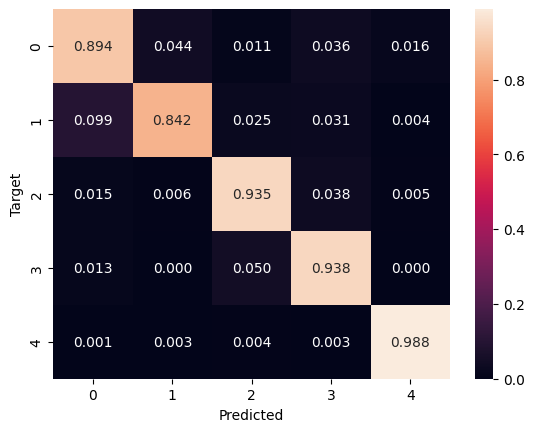

In [20]:
import seaborn as sns
import numpy as np


y_true = []
y_pred = []
#model = model.to("cpu")

#testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
print(f'test_results={np.round(cfm[cfm > 0.3], 3)}')
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

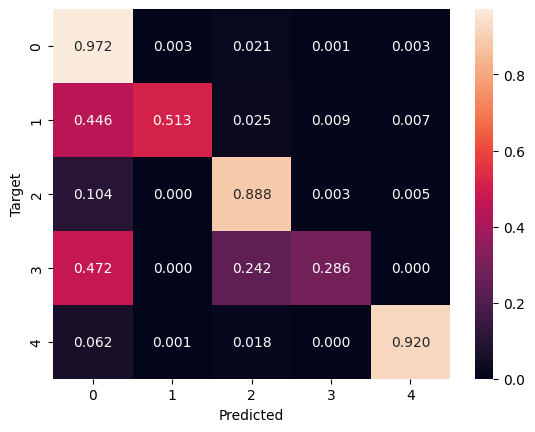

In [20]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

## EXPERIMENT LSTM

In [11]:
class LSTMmodel(nn.Module):
    def __init__(
        self,
        config: dict,
    ) -> None:
        super().__init__()
        print(config)
        self.rnn = nn.LSTM(
            input_size=config["input"],
            hidden_size=int(config["hidden"]),
            dropout=config["dropout"],
            batch_first=True,
            num_layers=int(config["num_layers"]),
        )
        # Fully connected layer
        self.dense = nn.Sequential(
            nn.Linear(int(config["hidden"]), config["hidden"]//10),
            nn.ReLU(),
            nn.Linear(config["hidden"]//10, config["hidden"]//4),
            nn.ReLU(),
            nn.Linear(config["hidden"]//4, config["hidden"]//2),
            nn.ReLU(),
            nn.Linear(config["hidden"]//2, config["output"])
        )
        

    def forward(self, x):
        x, _ = self.rnn(x)
        last_step = x[:, -1, :]
        yhat = self.dense(last_step)
        return yhat

In [12]:
#from src import models
#config LSTM
config = {
    "input": 1,
    "hidden": 128,  
    "dropout": 0.4,
    "output": 5,
    "num_layers": 3,
    
}
model = LSTMmodel(config)

{'input': 1, 'hidden': 128, 'dropout': 0.4, 'output': 5, 'num_layers': 3}


In [13]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "LSTM")
    mlflow.set_tag("dataset", "heart_big")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()

    #htop om de gpu te zien
    # dimensie transformer reduceren

2025-01-17 21:08:05.920 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250117-210805
100%|██████████| 547/547 [01:02<00:00,  8.78it/s]
2025-01-17 21:09:15.056 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.6899 test 0.6662 metric ['0.8244', '0.8244', '0.2700', '0.8244', '0.2978']
100%|██████████| 547/547 [01:04<00:00,  8.53it/s]
2025-01-17 21:10:25.650 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.6686 test 0.6474 metric ['0.8325', '0.8325', '0.2679', '0.8325', '0.2939']
100%|██████████| 547/547 [01:04<00:00,  8.44it/s]
2025-01-17 21:11:37.009 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.6591 test 0.6668 metric ['0.8240', '0.8240', '0.2669', '0.8240', '0.2936']
100%|██████████| 547/547 [01:05<00:00,  8.41it/s]
2025-01-17 21:12:48.542 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.6587 test 0.6863 metric ['0.8196', '0.8196', '0.2582', '0.8196', '0.2857']
100%|██████████| 547/547 [01:05<00:00,  8.29it

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

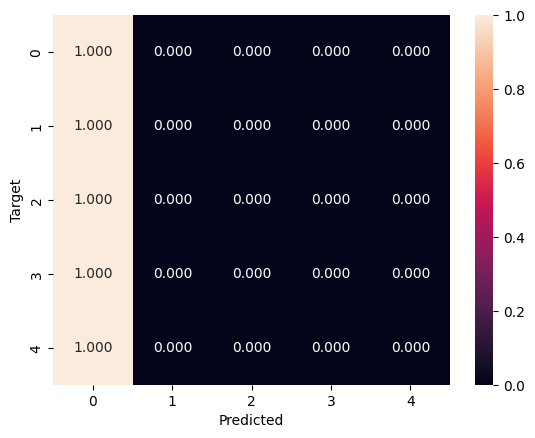

In [14]:
y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [28]:
#from src import models
#config GRU
config = {
    "input": 1,
    "hidden": 256,  # updated key
    "dropout": 0.1,
    "output": 5,
    "num_layers": 2,
}
model = GRUmodel(config)

{'input': 1, 'hidden': 256, 'dropout': 0.1, 'output': 5, 'num_layers': 2}


- Model GRU:

Hyperparameters:
- 256 hidden units
- 4 layers

In [31]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "GRU")
    mlflow.set_tag("dataset", "heart_big")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()

    #htop om de gpu te zien
    # dimensie transformer reduceren

2025-01-16 22:20:10.542 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250116-222010
100%|██████████| 547/547 [01:05<00:00,  8.31it/s]
2025-01-16 22:21:22.347 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5913 test 0.4227 metric ['0.8750', '0.8750', '0.4500', '0.8750', '0.4548']
100%|██████████| 547/547 [01:07<00:00,  8.12it/s]
2025-01-16 22:22:35.683 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.4105 test 0.3516 metric ['0.8994', '0.8994', '0.5772', '0.8994', '0.5830']
100%|██████████| 547/547 [01:07<00:00,  8.10it/s]
2025-01-16 22:23:49.196 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.3290 test 0.3067 metric ['0.9251', '0.9251', '0.6858', '0.9251', '0.7039']
100%|██████████| 547/547 [01:49<00:00,  5.01it/s]
2025-01-16 22:25:44.453 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2661 test 0.2121 metric ['0.9446', '0.9446', '0.7358', '0.9446', '0.7440']
100%|██████████| 547/547 [01:09<00:00,  7.92it

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

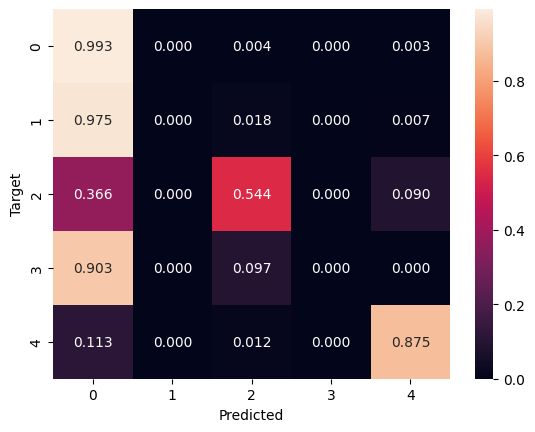

In [32]:
y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

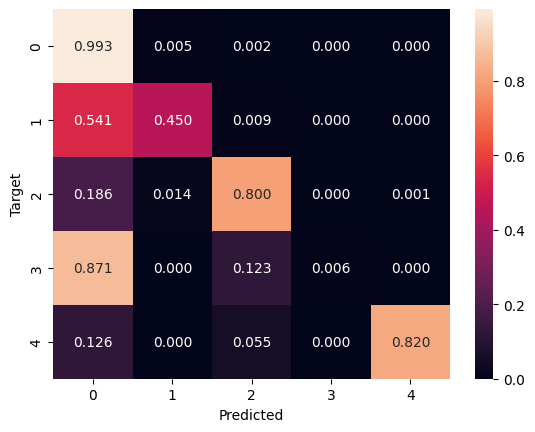

In [27]:
y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

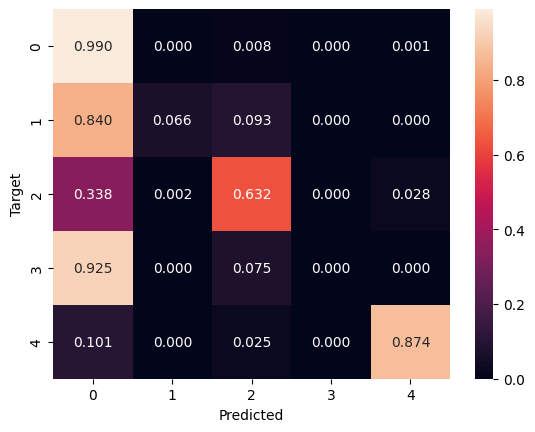

In [22]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

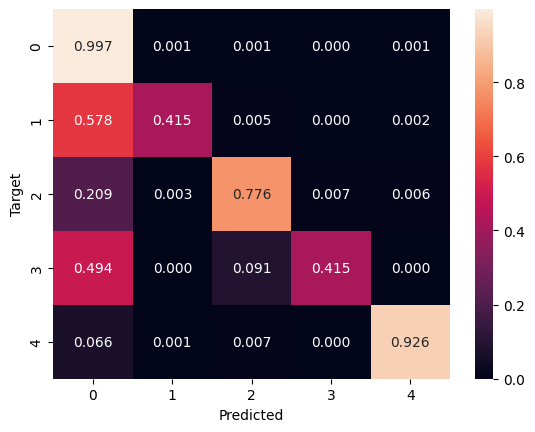

In [27]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")